## __Importando bibliotecas necessárias__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tfw
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import shutil

## __Defina o caminho para as pastas__

In [2]:
pathO = os.getcwd()
path = pathO + "\\produtos_regionais\\"
log_dir = pathO + "\\logsLote"
output_dir_bestModel = pathO + "\\models\\"
output_dir = pathO + "\\modelsLote\\"

## __Criar pasta de Logs__

In [3]:
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)  # Remove a pasta e todo o conteúdo
    print(f"Pasta existente removida: {log_dir}")

os.makedirs(log_dir)
print(f"Pasta criada: {log_dir}")

Pasta existente removida: C:\Users\PC\Documents\GitHub\treinandoEficcientNet2\logsLote
Pasta criada: C:\Users\PC\Documents\GitHub\treinandoEficcientNet2\logsLote


## __Criar o callback do TensorBoard__

In [4]:
tensorboard_callback = TensorBoard(log_dir=log_dir)

## __Configurações de Data Augmentation__

In [5]:
datagen = ImageDataGenerator(
    rescale=1./255,         
    rotation_range=10,      
    width_shift_range=0.1,   
    height_shift_range=0.1,  
    shear_range=0.1,        
    zoom_range=0.1,         
    horizontal_flip=True,    
    fill_mode='nearest'     
)

## __Gerando os dados de treino__

In [6]:
train_generator = datagen.flow_from_directory(
    directory=path + 'train',
    target_size=(224, 224),  # Redimensiona as imagens para 224x224 pixels
    class_mode='categorical',
    shuffle=True
)

Found 272 images belonging to 4 classes.


## __Gerando os dados de validação__

In [7]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    directory=path + 'val',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

Found 64 images belonging to 4 classes.


## __Gerando os dados de teste__

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Apenas normalização, sem augmentação

test_generator = test_datagen.flow_from_directory(
    directory=path + 'test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=false
)

Found 124 images belonging to 4 classes.


## __Definindo hiperparâmetros__

In [9]:
epochs_options = [30, 50]
batch_size_options = [16, 32]
learning_rate_options = [0.001, 0.0001]
optimizers_options = [Adam, SGD]

## __Treinando modelo__

In [10]:
results = []
cont=1
# Loop para treinar modelos com diferentes combinações de hiperparâmetros
for epochs in epochs_options:
    for batch_size in batch_size_options:
        for learning_rate in learning_rate_options:
            for optimizer in optimizers_options:
                try:
                    print("Treinamento: "+cont+"; Épocas: "+epochs+"; Batch Size: "+batch_size+"; Learning Rate: "+learning_rate+"; Optimizer: "+optimizer.__name__+";")
                    # Configurando os geradores de dados
                    train_generator.batch_size = batch_size
                    validation_generator.batch_size = batch_size
                
                    base_model = EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
                    # Congelar as camadas iniciais para não treinar novamente
                    for layer in base_model.layers[-100:]:
                        layer.trainable = False
                        
                    x = base_model.output
                    x = GlobalAveragePooling2D()(x)
                    x = Dropout(0.5)(x)  # Dropout com 50%
                    x = Dense(128, activation='relu')(x)
                    x = Dropout(0.5)(x)
                    predictions = Dense(len(train_generator.class_indices), 
                                    activation='softmax')(x)
                    model = Model(inputs=base_model.input, outputs=predictions)
                    
                    # Compilando o modelo
                    model.compile(optimizer=optimizer(learning_rate=learning_rate), 
                                  loss='categorical_crossentropy', 
                                  metrics=['accuracy'])
                    
                    # Treinando o modelo
                    history = model.fit(
                        train_generator,
                        epochs=epochs,
                        validation_data=validation_generator,
                        callbacks=[tensorboard_callback]
                    )
                    # Avaliando o modelo
                    
                    if(cont==1):
                        best_model=model
                    
                    final_loss, final_accuracy = model.evaluate(validation_generator)
                    best_loss, best_accuracy = best_model.evaluate(validation_generator)
                    if(best_accuracy<final_accuracy):
                        best_model = model
                        
                    results.append({
                        'epochs': epochs,
                        'batch_size': batch_size,
                        'learning_rate': learning_rate,
                        'optimizer': optimizer.__name__,
                        'train_loss': history.history['loss'][-1],  # A última perda de treino
                        'train_accuracy': history.history['accuracy'][-1],  # A última acurácia de treino
                        'val_loss': history.history['val_loss'][-1],  # A última perda de validação
                        'val_accuracy': history.history['val_accuracy'][-1],  # A última acurácia de validação
                        'history': history  # Armazenando o histórico completo
                    })
                    cont+=1
                except Exception as e:
                    print(f"model_epochs{epochs}_batch{batch_size}_lr{learning_rate}_{optimizer} {e}")

Epoch 1/30
17/17 [==============================] - 49s 2s/step - loss: 0.4625 - accuracy: 0.8419 - val_loss: 1.4316 - val_accuracy: 0.2500
Epoch 2/30
17/17 [==============================] - 58s 3s/step - loss: 0.0759 - accuracy: 0.9743 - val_loss: 1.4055 - val_accuracy: 0.2500
Epoch 3/30
17/17 [==============================] - 54s 3s/step - loss: 0.0743 - accuracy: 0.9816 - val_loss: 1.4725 - val_accuracy: 0.0938
Epoch 4/30
17/17 [==============================] - 70s 4s/step - loss: 0.0485 - accuracy: 0.9890 - val_loss: 2.6918 - val_accuracy: 0.2500
Epoch 5/30
17/17 [==============================] - 94s 5s/step - loss: 0.0653 - accuracy: 0.9926 - val_loss: 1.2818 - val_accuracy: 0.5938
Epoch 6/30
17/17 [==============================] - 74s 4s/step - loss: 0.0831 - accuracy: 0.9743 - val_loss: 1.4376 - val_accuracy: 0.1250
Epoch 7/30
17/17 [==============================] - 33s 2s/step - loss: 0.3473 - accuracy: 0.9375 - val_loss: 1.5478 - val_accuracy: 0.1719
Epoch 8/30
17/17 [==

## __Convertendo resultados em DataFrame__

In [11]:
results_df = pd.DataFrame(results)
folder_path=pathO+"\\resultados\\"
csv_file_path = os.path.join(folder_path, 'results_treinoLote9_.csv')
results_df.to_csv(csv_file_path, index=False)
print(results_df)

    epochs  batch_size  learning_rate optimizer  final_loss  final_accuuracy  \
0       30          16         0.0010      Adam    1.994524         0.093750   
1       30          16         0.0010       SGD    0.935387         0.796875   
2       30          16         0.0001      Adam    0.204663         0.937500   
3       30          16         0.0001       SGD    1.392614         0.234375   
4       30          32         0.0010      Adam    0.872607         0.750000   
5       30          32         0.0010       SGD    1.213626         0.609375   
6       30          32         0.0001      Adam    0.188106         0.953125   
7       30          32         0.0001       SGD    1.338675         0.390625   
8       50          16         0.0010      Adam    0.335422         0.937500   
9       50          16         0.0010       SGD    1.276095         0.468750   
10      50          16         0.0001      Adam    0.119647         0.968750   
11      50          16         0.0001   

## __Salvar o melhor modelo separadamente__

In [13]:
model_name = f"best_model_epochs{best_epoch}_batch{best_batch_size}_lr{best_learning_rate}_{best_optimizer}_treinoLote9.h5"
best_model.save(os.path.join(output_dir_bestModel, model_name), save_format='h5')

## ___Carregando o modelo salvo___

In [ ]:
load_model = load_model(path_load +"individual_model_epochs20_batch32_lr0.0001_Adam_modelo95.h5")
print("Modelo carregado com sucesso.")

## ___Carregando o Dataframe salvo___

In [ ]:
folder_path=pathO+"\\resultados\\results_modelo95.csv"
df = pd.read_csv(folder_path)

lista = df.values.tolist()
print(lista)

## __Encontrar o melhor modelo com base na acurácia de validação__

In [14]:
best_accuracy = 0
best_history = None

# Iterar sobre os resultados para encontrar o modelo com a maior val_accuracy
for result in results:
    val_accuracy = result.get('val_accuracy', 0)  # Obtém a acurácia de validação
    
    # Verifica se a acurácia de validação é maior que a atual
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_history = result  # Armazena o histórico do melhor modelo

## __Gerar gráfico do melhor modelo__

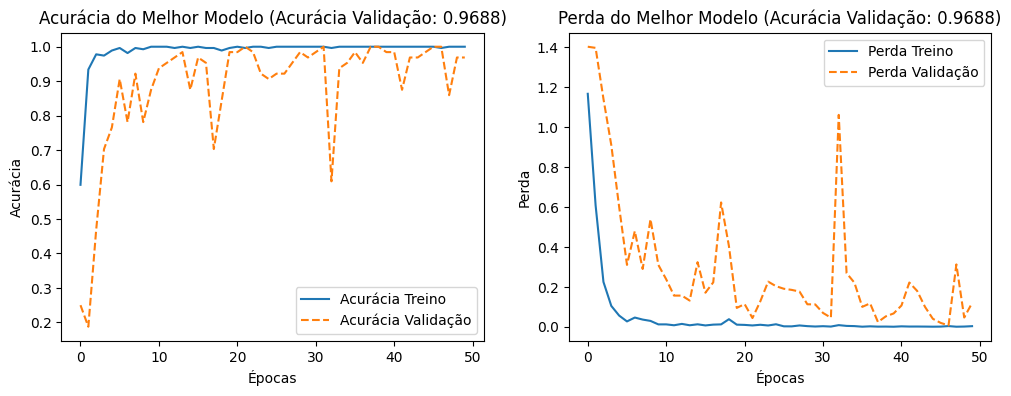

In [15]:
if best_history:
    plt.figure(figsize=(12, 4))
    
    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(best_history['history'].history['accuracy'], label='Acurácia Treino')
    plt.plot(best_history['history'].history['val_accuracy'], label='Acurácia Validação', linestyle='--')
    plt.title(f"Acurácia do Melhor Modelo (Acurácia Validação: {best_accuracy:.4f})")
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    
    # Gráfico de Perda
    plt.subplot(1, 2, 2)
    plt.plot(best_history['history'].history['loss'], label='Perda Treino')
    plt.plot(best_history['history'].history['val_loss'], label='Perda Validação', linestyle='--')
    plt.title(f"Perda do Melhor Modelo (Acurácia Validação: {best_accuracy:.4f})")
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Exibindo os gráficos
    plt.show()
else:
    print("Nenhum modelo foi encontrado.")

## __Gerando a matriz de confusão para o melhor modelo__

In [16]:
y_true = validation_generator.classes
y_pred = best_model.predict(validation_generator)  # Não precisa de ['model'], apenas use o objeto diretamente
y_pred_classes = np.argmax(y_pred, axis=1)

2/2 [==============================] - 5s 2s/step


## __Criando a matriz de confusão__

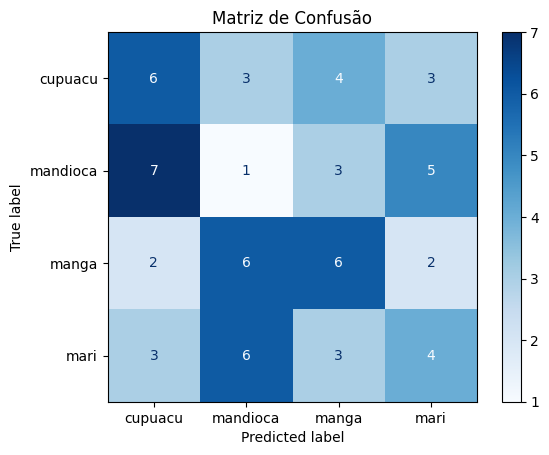

In [17]:
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

## __Avaliação do modelo com o conjunto de teste__

In [18]:
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Loss no conjunto de teste: {test_loss}")
print(f"Acurácia no conjunto de teste: {test_accuracy}")

4/4 [==============================] - 9s 2s/step - loss: 0.0838 - accuracy: 0.9597
Loss no conjunto de teste: 0.08377966284751892
Acurácia no conjunto de teste: 0.9596773982048035


## __Função de Predição__

In [19]:
def predict_image_class(image_path, model, class_indices):
    # Carregar a imagem
    img = load_img(image_path, target_size=(224, 224))  # Redimensiona para o tamanho usado no modelo
    img_array = img_to_array(img)  # Converte para array numpy
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona uma dimensão para lote
    img_array = img_array / 255.0  # Normaliza os valores para o intervalo [0, 1]

    # Previsão
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions, axis=-1)[0]  # Índice da classe com maior probabilidade

    # Mapeando índice para a classe
    class_labels = {v: k for k, v in class_indices.items()}  # Inverte o mapeamento
    predicted_class = class_labels[predicted_class_idx]

    return predicted_class

## __Exemplo de Previsão__

In [20]:
image_path = pathO + "\\to_predict\\cupuacu.jpg"
predicted_class = predict_image_class(image_path, best_model, train_generator.class_indices)
print(f"A imagem pertence à classe: {predicted_class}")

1/1 [==============================] - 1s 1s/step
A imagem pertence à classe: mandioca


## __Finalizando o TensorBoard__

In [ ]:
%load_ext tensorboard
%tensorboard --logdir .\logsLote